### DEBUG - TST1907

In [1]:
# Utils
import random
import numpy as np
import matplotlib.pyplot as plt

# Torch
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
UAP_PATH = "perturbations/uap_vgg16.npy"
DATASET_DIR = './dataset/train/'

In [3]:
def process_image(img, transpose=False, numpy=False):
    """
    Preprocess the images to displays them in a plot.

    Parameters:
    - img: The image to preprocess.
    - transpose: Bool value if the img needs to be transposed.
    - numpy: Flag to identify if the image is already in a numpy array.

    Returns:
    - img: The image preprocessed.       
    """        
    if transpose:
        if numpy is False:
            img = img.numpy()
        img = img.transpose((1, 2, 0)) # Transform (X, Y, Z) shape
    img = (img - img.min()) / (img.max() - img.min()) # Clip the image to [0, 255] values
    return img


In [4]:
def obj_variance(obj, type=None):
    """
    Display the maximum and minimum value in a given object.

    Parameters:
    - obj: A given object.
    - type: Object type. Can be "tensor" and "numpy".
    """

    if type == "tensor":
        tensor_min = torch.min(obj)
        tensor_max = torch.max(obj)
        
        print("Maximum value:", "{:.5f}".format(tensor_max.item()))
        print("Minimum value:", "{:.5f}".format(tensor_min.item()))
    else:
        numpy_min = "{:.5f}".format(np.max(obj))
        numpy_max = "{:.5f}".format(np.min(obj))
        
        print("Maximum value:", numpy_max)
        print("Minimum value:", numpy_min)

In [5]:
def get_min_max(tensor):
    min_val = torch.min(tensor)
    max_val = torch.max(tensor)
    print("Min: " + str(min_val))
    print("Max: " + str(max_val))

In [6]:
def normalize(x):
    mean = torch.Tensor([0.485, 0.456, 0.406])
    std = torch.Tensor([0.229, 0.224, 0.225])
    return (x - mean.type_as(x)[None,:,None,None]) / std.type_as(x)[None,:,None,None]

In [7]:
def get_uap(path, device):
    uap = np.load(path)
    uap = torch.tensor(uap, device=device)
    return uap

In [8]:
### @joseareia -- 2024-07-19
def prepare_model(model_name, device):
    model = getattr(models, model_name)(pretrained=True).to(device)
    return model

In [9]:
def get_data_loader(dataset_name, dataset, batch_size=1, shuffle=True, analyze=True):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
    
    val_dataset =  datasets.ImageFolder(dataset, transform=transform)
    
    if analyze == True:
        dataset = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0)
        return dataset
        
    ### Beginning of changes by @joseareia -- 2024-07-16
    total_images = len(val_dataset)
    subset_size = 500
    assert subset_size <= total_images, "Subset size is larger than the dataset!"
    subset_indices = random.sample(range(total_images), subset_size)
    subset_dataset = torch.utils.data.Subset(val_dataset, subset_indices)

    N = int(subset_size*0.02)
    split_sizes = [N, subset_size - N]
    split_sizes_test = [N, split_sizes[1] - N]

    train_dataset, test_dataset = torch.utils.data.random_split(subset_dataset, split_sizes)
    test_dataset, _ = torch.utils.data.random_split(test_dataset, split_sizes_test)
    ### End of changes by @joseareia

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0)

    return train_loader, test_loader

In [10]:
%%time
uap = get_uap(UAP_PATH, DEVICE)

CPU times: user 1.45 s, sys: 918 ms, total: 2.36 s
Wall time: 2.36 s


In [11]:
%%time
test_model = prepare_model('vgg16', DEVICE)

CPU times: user 998 ms, sys: 505 ms, total: 1.5 s
Wall time: 1.1 s


In [12]:
%%time
test_loader = get_data_loader('imagenet', dataset=DATASET_DIR, batch_size=1, shuffle=True, analyze=True)

CPU times: user 239 ms, sys: 69.1 ms, total: 308 ms
Wall time: 306 ms


In [ ]:
# %%time
# final_fooling_rate, adv_images = get_fooling_rate(test_model, torch.clamp(uap, -10/255, 10/255), test_loader, DEVICE)

---

### DEBUG --- UAP

In [13]:
obj_variance(uap, type="tensor")

Maximum value: 0.03922
Minimum value: -0.03922


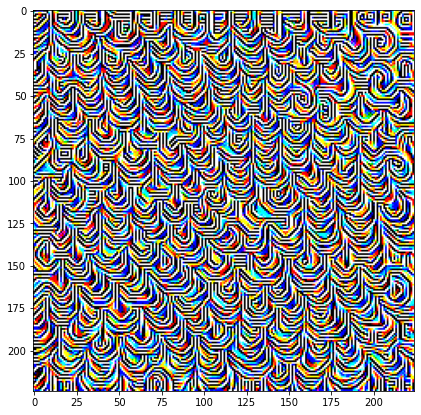

In [14]:
uap_processed = process_image(uap.squeeze().cpu(), transpose=True, numpy=False)
plt.figure(figsize = (7,7))
plt.imshow(uap_processed)

---

### DEBUG --- ADV IMAGES

In [15]:
model = test_model
delta = torch.clamp(uap, -10/255, 10/255)
data_loader = test_loader

In [16]:
flipped = 0
total = 0

model.eval()
with torch.no_grad():
    for batch in data_loader:
        images, labels = batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(normalize(images))
        _, predicted = torch.max(outputs.data, 1)

        adv_images = torch.add(delta, images).clamp(0, 1)
        adv_outputs = model(normalize(adv_images))

        _, adv_predicted = torch.max(adv_outputs.data, 1)

        total += images.size(0)
        flipped += (predicted != adv_predicted).sum().item()
        
        break

In [17]:
obj_variance(adv_images, type="tensor")

Maximum value: 1.00000
Minimum value: 0.00000


In [18]:
predicted

tensor([89], device='cuda:0')

In [19]:
adv_predicted

tensor([794], device='cuda:0')

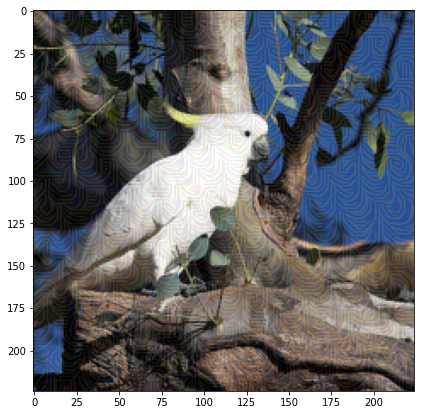

In [20]:
adv_images_processed = process_image(adv_images.squeeze().cpu(), transpose=True, numpy=False)
plt.figure(figsize = (7,7))
plt.imshow(adv_images_processed)